# Multitaper spectrum - even vs uneven temporal cadence

In this example, we compare an unequally spaced version of something we know with something equally spaced. We choose to simulate an evenly-spaced sample of zero-mean, [Matérn covariance](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) Gaussian data. Computing the true spectrum is trivial, and we compare it with the evenly spaced multitaper estimate. Then, deleting a small number of points, we compute the Bronez spectrum and compare with the missing-data multitaper estimate of Chave. 

In [1]:
using Multitaper, Plots
using LombScargle, Random

include(dirname(dirname(pathof(Multitaper)))*"/Examples/pgram.jl")
include(dirname(dirname(pathof(Multitaper)))*"/Examples/single_tapers.jl")
include(dirname(dirname(pathof(Multitaper)))*"/Examples/matern.jl")

function fejer(N)
  fey = [(1/N)*(1-cos(N*x))/(1-cos(x)) for x in LinRange(-1.0, 1.0, N+1)[1:N]]
  fey[Int64(N/2 + 1)] = N
  return fftshift(N*fey/sum(fey))[vcat(N, collect(1:N-1))]
end 


fejer (generic function with 1 method)

Compute a sample time series having 1024 points, with Matérn covariance structure.

In [2]:
N = 1_024 
N2 = 513
freq = LinRange(-0.5, 0.5, N+1)[1:N]

phi = 1.0
a = 0.1
nu = 1.5
flr = 0.0

# True spectrum
S = maternsdf.(freq, phi, a, nu, flr)

# Simulate some data
dat = Matern_sim([phi, a, nu, flr], N)[1];

Here is a periodogram estimate of these data. 

In [3]:
Pxx = sm_pgram(dat, taper = :dirichlet)
Direct = sm_pgram(dat)

direct(range(0.0, stop=0.5, length=512), [77825.19508728896, 155650.35404333286, 19470.331981637562, 23848.568307518384, 47218.56541464048, 27417.297192322996, 248.16845537801495, 15651.446005827394, 9033.393828154078, 63057.54236361951  …  0.015927436329338247, 0.019452776305649677, 0.0060453118200839194, 0.002505044192245527, 0.01218798428463816, 0.006583335424100961, 0.025040508245973616, 0.06656918409368505, 0.029351048106798516, 0.03613124505587649], (:default, 0.1), (:daniell, 1), 1, 0.0)

Compute the multitaper estimate as well, with default (NW = 4, K = 6) parameters.

In [4]:
MT = multispec(dat)

MTSpectrum{Nothing,Nothing,Nothing}(0.0:0.0009765625:0.5, [50434.18877973198, 49852.59895833046, 53140.81186239994, 38532.90499127129, 39693.87781241864, 17339.193975793987, 23581.895308034163, 22989.41862156968, 15295.266767911688, 15669.16818428383  …  0.04443650081712485, 0.05116774402594825, 0.03787027487147594, 0.03376705361139406, 0.029306353240732885, 0.05847682016135084, 0.05739756606798086, 0.04727655197592562, 0.04285477359858433, 0.05505677195303271], nothing, MTParameters(4.0, 6, 1024, 1.0, 1024, 1, nothing), nothing, nothing, nothing, nothing)

Compare the equally-spaced estimates against the truth. Note the terrible performance of the ordinary (Dirichlet tapered) periodogram. The 10% cosine tapered estimated (the default in R, for numerous reasons) performs much better on a sample with 50-dB range. 
Finally, the multitaper estimator (overlaid) has the least variance of the three.

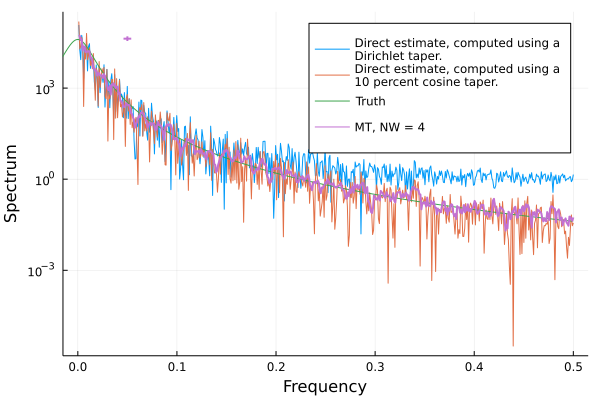

In [5]:
plot(Pxx)
plot!(Direct)
plot!(freq, S*4, xlims = [0, 0.5], label = "Truth")
plot!(MT, label = "MT, NW = 4", linewidth = 2)

## Unequal spacing

Now, to examine the performance of an unequally-spaced estimator on more-or-less the same data, I delete a small number of points. 
This is not actually unequal spacing. It is actually called the missing-data problem. 
Here I plot the data to see where data is missing (and where it isn't).

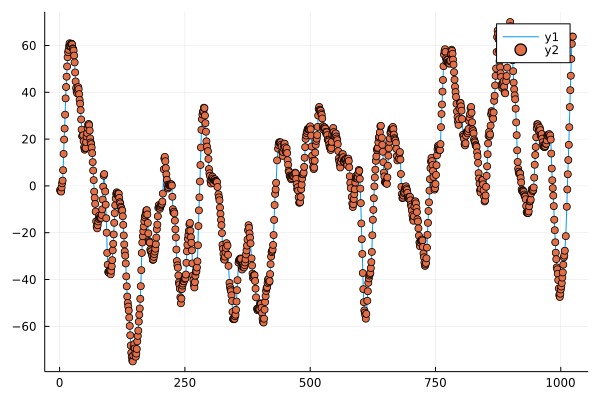

In [6]:
# I will delete exactly 24 points, so the results should be GOOD
times = unique(sort(vcat(1, randperm(N)[1:1000], N)))
plot(times, dat[times])
scatter!(times, dat[times])

Choose the parameters for a bronez (`bspec`) estimate of the above, and compute it. This cell takes some time, as fresh tapers are computed at every frequency.

In [7]:
w = 4.0/N
bet = 0.5

Sb = bspec(Float64.(times), dat[times], w, 3, bet, 0.0, false) # (times, dat, W, K, beta, nz, Ftest)

MTSpectrum{EigenCoefficient,Array{Float64,1},Nothing}([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009  …  0.49, 0.491, 0.492, 0.493, 0.494, 0.49500000000000005, 0.49599999999999994, 0.497, 0.498, 0.499], [12933.618211091363, 13038.027907811638, 13048.91123470789, 10029.631686487328, 7325.265081023994, 6427.330663898728, 5293.702402739178, 4586.351732963572, 3278.774152545278, 5563.525637255355  …  0.36125565915278185, 0.43671366394501204, 0.6110185304379386, 0.4973865443926398, 0.8322700598982579, 0.9988754286593148, 2.280005623211212, 1.0645966582939608, 0.8894173654323239, 0.7121728103615474], nothing, MTParameters(3.90625, 3, 1000, 1.0, 1000, 1, nothing), EigenCoefficient(Complex{Float64}[-125.36593880180718 - 1.8726260319828837e-14im 53.891876155626704 - 1.1533401148579273e-14im 142.0559808879662 - 5.088833461081454e-15im; -76.75664566229408 + 134.52583222627618im 53.45626898744744 + 94.50451961825965im 3.8342419158704057 + 57.636127563620775im; … ; -0.271843661

Now we use the `LombScargle.jl` package to compute the Lomb-Scargle periodogram. 

In [8]:
LS = lombscargle(Float64.(times), dat[times], normalization=:psd)

f,P = freqpower(LS)

(9.775171065493646e-5:0.00019550342130987292:2.4436950146627567, [60531.03970677902, 64651.06015219481, 73853.91626064604, 89670.39071624186, 110490.45511897505, 117335.69014583329, 80253.39231371248, 29247.2030911836, 5433.0149475185535, 9951.55722527781  …  62.68163681488404, 48.875467440512104, 29.903849914089108, 16.213373592576975, 15.099764802074663, 24.56872098352915, 35.346534495063814, 38.40708970684986, 31.5598063934779, 19.980860862649156])

Plotting all of the estimates together, we find significantly worse performance for all of the estimators in much of the frequency range. 

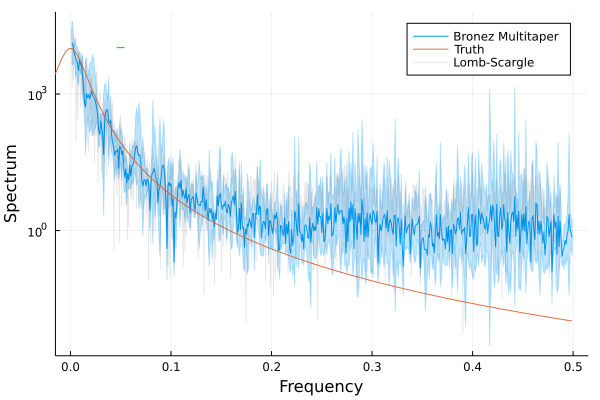

In [9]:
pl = plot(Sb, label = "Bronez Multitaper")
plot!(pl, freq, S, xlims = [0, 0.5], label = "Truth")
# Note the odd division by 4 to compare magnitudes
plot!(pl, f[1:2500],P[1:2500]/4, yscale = :log10, label = "Lomb-Scargle", linealpha = 0.1, c = :black)

And just out of curiosity, I have decided to plot the spectral windows for this observing cadence (for the periodogram, that is) to see how much range they have. 

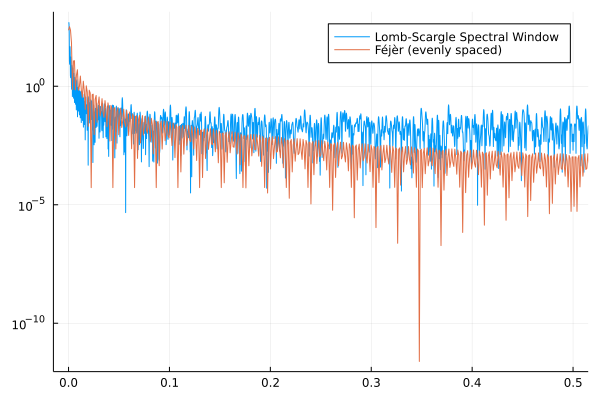

In [10]:
SW = lombscargle(Float64.(times), ones(length(times)), center_data = false, 
    fit_mean = false, normalization=:psd)
f,PW = freqpower(SW)

spw = plot(f,PW, yscale=:log10, label = "Lomb-Scargle Spectral Window", xlims = [0,0.5])

FK = fejer(N)
plot!(spw, LinRange(0, 1, N+1)[1:N], FK, yscale = :log10, label="Féjèr (evenly spaced)")

Let's look at the results for the Bronez spectrum.

In [15]:
using FINUFFT

In [34]:
M   = length(Sb.f)
K   = Sb.params.K
ff  = collect(Sb.f)
tt  = Float64.(times)
lam = zeros(M, K)
u   = zeros(M, K)
Win = zeros(M, M)

function fillwin!(Win, lam, w, K, tt, ff)
    for (i, fr) in enumerate(ff)
        lam[i, :], u = Multitaper.gpss_orth(w, K, tt, fr)
        Win[i, :] = mean(mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, ff)), hcat, 1:K), dims = 2)
    end
end

fillwin!(Win, lam, w, K, tt, ff)

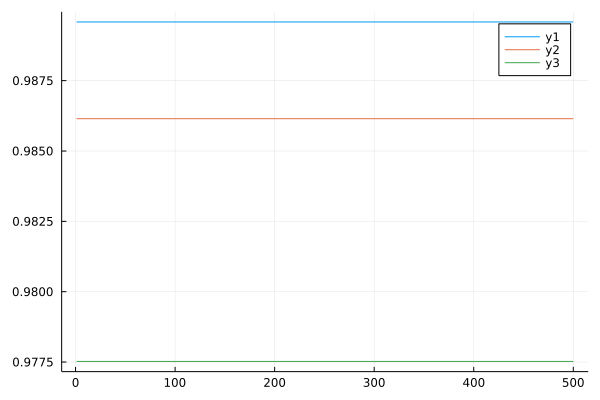

In [48]:
plot(lam)

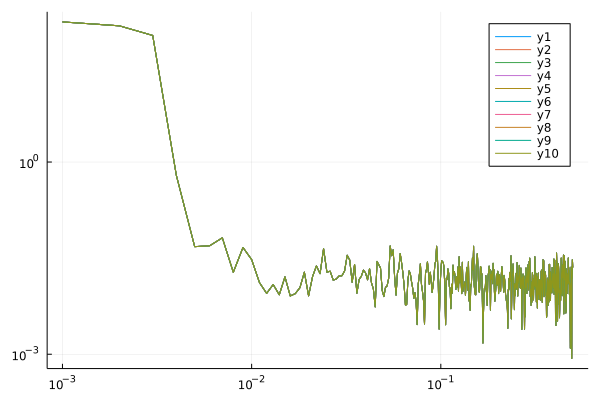

In [46]:
plot(ff[2:end], Win[1:50:end,2:end]',  yscale = :log10, xscale = :log10)

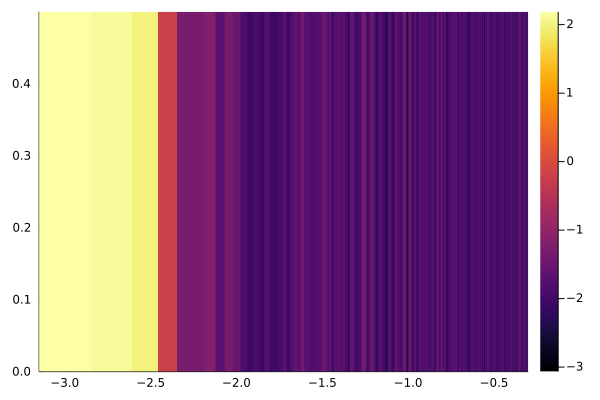

In [47]:
heatmap(log10.(ff[2:end]),ff,log10.(Win[:,2:end]))

## Missing data problem

Since this is actually a missing data problem, we can go ahead and compute Chave's missing-data Slepian sequences and obtain a missing-data multitaper estimate. 

NOTE: This useage is really not as Chave (or I) recommend - the missing data tapers really excel on data for which decently long gaps are missing, not individual points spaced out over the entire dataset.

There is no missing data periodogram estimator in the literature. 

In [11]:
Smd = mdmultispec(Float64.(times), dat[times]);

Degrees of freedom get too small to assess F-test p-value.


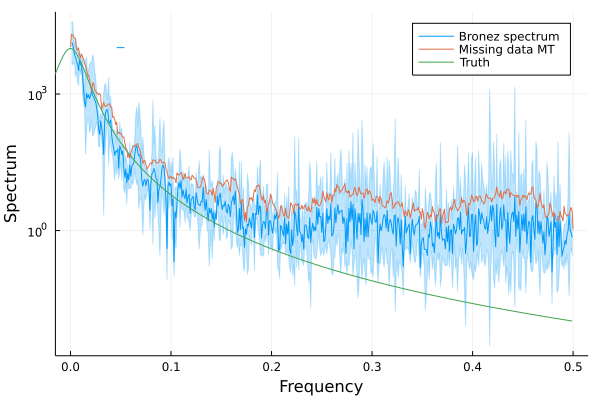

In [12]:
plot(Sb, label = "Bronez spectrum")
plot!(Smd.f, Smd.S/2, label="Missing data MT")
plot!(freq, S, xlims = [0, 0.5], label = "Truth")

Disappointing performance on all counts. I encourage the reader to run this code, varying the Matérn parameters $\nu, a$ to decrease the dynamic range of the true spectrum, for better results. 